In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/GSU/Spring 2025/CSC 8260 Adv Img Prc/Project/images/'


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
import time


In [ ]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# Load VGG19 pre-trained on ImageNet without the classification head
base_model = vgg19.VGG19(weights='imagenet', include_top=False)
print('Model loaded.')

# Define the layers that you are interested in for style and content
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']



# Combine them in a single model that outputs both style and content layers
# Using layer names to fetch outputs directly
outputs = [base_model.get_layer(name).output for name in style_layers + content_layers]
model = Model(inputs=base_model.input, outputs=outputs)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model loaded.


In [ ]:
def extract_features(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # Pass them through the model to get the feature maps from desired layers
    content_outputs = model(content_image)
    style_outputs = model(style_image)

    return content_outputs[-1], style_outputs[:-1]



In [ ]:
def content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))

def style_loss(base_style, style_target):
    # Compute gram matrices for comparison
    gram_base_style = gram_matrix(base_style)
    gram_style_target = gram_matrix(style_target)
    return tf.reduce_mean(tf.square(gram_base_style - gram_style_target))


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations




In [ ]:
from PIL import Image, ImageOps
import tensorflow as tf
import numpy as np


def load_and_process_img(image_path, target_width=1024):
    # Load image with PIL and fix EXIF orientation
    img_pil = Image.open(image_path)
    img_pil = ImageOps.exif_transpose(img_pil)  # Fix sideways rotation

    # Resize while maintaining aspect ratio
    orig_width, orig_height = img_pil.size
    scale = target_width / orig_width
    new_height = int(orig_height * scale)
    img_pil = img_pil.resize((target_width, new_height))

    #Convert to TensorFlow tensor
    img_np = np.array(img_pil)
    img_tf = tf.convert_to_tensor(img_np, dtype=tf.float32) / 255.0  # Normalize to [0, 1]
    img_tf = tf.expand_dims(img_tf, axis=0)  # Add batch dimension

    return img_tf


def get_original_width(image_path):
    """Returns the original width of an image."""
    img = Image.open(image_path)
    return img.size[0]  # (width, height)


In [ ]:
def compute_loss(model_outputs,
                 content_target,
                 style_targets,
                 style_layers,
                 style_layer_weights,
                 target_image,
                 content_weight,
                 style_weight,
                 tv_weight):

    style_outputs = model_outputs[:-1]
    content_output = model_outputs[-1]

    # Content Loss
    content_loss_val = content_loss(content_output, content_target)

    # Style Loss
    style_loss_val = 0.0
    for i, name in enumerate(style_layers):
        weight = style_layer_weights.get(name, 1.0)
        style_loss_val += weight * style_loss(style_outputs[i], style_targets[i])

    # Total Variation Loss (for smoother output)
    tv_loss = tf.image.total_variation(target_image)
    # Total Loss
    total_loss = (
        content_weight * content_loss_val +
        style_weight * style_loss_val
        + tv_weight * tv_loss  # adds regularization
    )


    return total_loss


In [ ]:
from IPython import display
@tf.function
def train_step(model, target_image, content_image, style_image,
               style_layers, style_layer_weights, optimizer,content_weight,  style_weight, tv_weight):
    with tf.GradientTape() as tape:
        content_features = model(content_image)[-1]
        style_features = [model(style_image)[i] for i in range(len(style_layers))]
        loss = compute_loss(
            model_outputs=model(target_image),
            content_target=content_features,
            style_targets=style_features,
            style_layers=style_layers,
            style_layer_weights=style_layer_weights,
            target_image=target_image,
            content_weight=content_weight,
            style_weight=style_weight,
            tv_weight=tv_weight
            )

    grads = tape.gradient(loss, target_image)
    optimizer.apply_gradients([(grads, target_image)])
    return loss


In [ ]:
def run_style_transfer(model, content_path, content_weight, style_path, style_weight,style_layer_weights, tv_weight, num_iterations=500):
    start = time.time()
    if not isinstance(content_path, str) or not isinstance(style_path, str):
        raise TypeError("Paths must be strings.")


    input_width = get_original_width (content_path)
    target_width = min(input_width, 1300)

    content_image = load_and_process_img(content_path, target_width)
    style_image = load_and_process_img(style_path, target_width)

    target_image = tf.Variable(content_image, dtype=tf.float32)


    # optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)  # Adjust hyperparameters

    initial_learning_rate = 0.02
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=100,      # How often to decay
        decay_rate=0.9,       # Multiply LR by this every `decay_steps`
        staircase=True        # If True, decay in discrete intervals (optional)
    )
    optimizer = tf.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.99, epsilon=1e-7)




    _ = optimizer.apply_gradients([(tf.zeros_like(target_image), target_image)])

    for i in range(num_iterations):
        loss = train_step(
              model, target_image, content_image, style_image,
              style_layers, style_layer_weights, optimizer,content_weight, style_weight, tv_weight
          )
        print(".", end='', flush=True)
        if i % 100 == 0:
            display.clear_output(wait=True)
            current_lr = lr_schedule(i).numpy()
            print(f"Step {i}, Loss: {loss.numpy().item():.4f}, Learning Rate: {current_lr:.6f}")
            # Show intermediate image
            display_images([target_image], titles=[f"Step {i}"], figsize=(6, 6))
            end = time.time()
            print(f"⏱️ Execution time: {end - start:.2f} seconds")

    display.clear_output(wait=True)
    display_images([target_image], titles=[f"Step {i}"], figsize=(6, 6))

    end = time.time()
    print(f"⏱️ Execution time: {end - start:.2f} seconds")
    return target_image



In [ ]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
import pytz



def save_styled_image(styled_image, content_image_path, style_image_path, output_dir):
    """
    Saves the styled image with a unique filename based on content and style image names and timestamp.

    Args:
    - styled_image (np.array): The final styled image to save.
    - content_image_path (str): Path to the content image.
    - style_image_path (str): Path to the style image.
    - output_dir (str): Directory where the styled image will be saved.
    """
    output_dir =  data_path+ 'results/'
    os.makedirs(output_dir, exist_ok=True)

    # Extract file names from the paths
    content_image_name = os.path.splitext(os.path.basename(content_image_path))[0]
    style_image_name = os.path.splitext(os.path.basename(style_image_path))[0]

    local_tz = pytz.timezone('America/New_York')

    local_time = datetime.datetime.now(local_tz)

    timestamp = local_time.strftime("%Y%m%d-%H%M%S")
    filename_base = f"{content_image_name}__plus_{style_image_name}__{timestamp}"
    file_path = os.path.join(output_dir, f"{filename_base}.png")

    input_image_resize = get_original_width(content_image_path)
    # Create a figure and axis with specific dimensions
    new_dpi = input_image_resize / 6
    fig, ax = plt.subplots(figsize=(6, 6), dpi=new_dpi)  # Adjust 'dpi' for resolution needs
    ax.imshow(np.squeeze(styled_image))  # Squeeze removes any singleton dimensions (e.g., batch size of 1)
    ax.axis('off')  # Turn off the axis

    # Remove padding and margins around the image
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
    ax.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    # Save the image with no padding and no border at a high resolution
    fig.savefig(file_path, format='png', bbox_inches='tight', pad_inches=0.0)
    plt.close(fig)

    params = {
    "content_image": content_image_path,
    "style_image": style_image_path,
    "content_weight": content_weight,
    "style_weight": style_weight,
    "tv_weight":tv_weight,
    "style_layer_weights": style_layer_weights,
    "num_iterations": EPOCH
    }

    config_dir = os.path.join(data_path, 'configs')
    os.makedirs(config_dir, exist_ok=True)

    json_path = os.path.join(config_dir, f"{filename_base}.json")
    with open(json_path, "w") as f:
        json.dump(params, f, indent=4)

    print(f"Saved config to {json_path}")


    print(f"Image saved as {file_path}")
    return filename_base , new_dpi




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

def display_images(images, titles=None, figsize=(18, 6), save_path=None, file_name=None, set_dpi = None):
    """
    Display a list of images with optional titles.

    Args:
        images (list): List of images (NumPy arrays or Tensors) to display.
        titles (list of str, optional): List of titles for each image.
        figsize (tuple): Figure size in inches.
    """
    plt.figure(figsize=figsize, dpi=100)
    num_images = len(images)

    for i, image in enumerate(images):
        if tf.is_tensor(image):
            image = image.numpy()  # Convert TensorFlow tensor to NumPy array
        image = np.squeeze(image)  # Remove batch dimension if present
        image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()

    if save_path and file_name:
      save_path = save_path + 'three_results/'
      os.makedirs(save_path, exist_ok=True)
      full_path = os.path.join(save_path, file_name)
      plt.savefig(full_path, bbox_inches='tight', dpi = set_dpi)
      print(f"Saved figure to {full_path}")


    plt.show()


In [ ]:
# Set style layer weights
style_layer_weights = {
    'block1_conv1': 10,
    'block2_conv1': 10,
    'block3_conv1': 0.001,
    'block4_conv1': 0.001,
    'block5_conv1': 1
}

# Set style, content and tv weights
content_weight = 1e5
style_weight = 1e5
tv_weight = 1e-6

# Set number of iterations
EPOCH = 1000



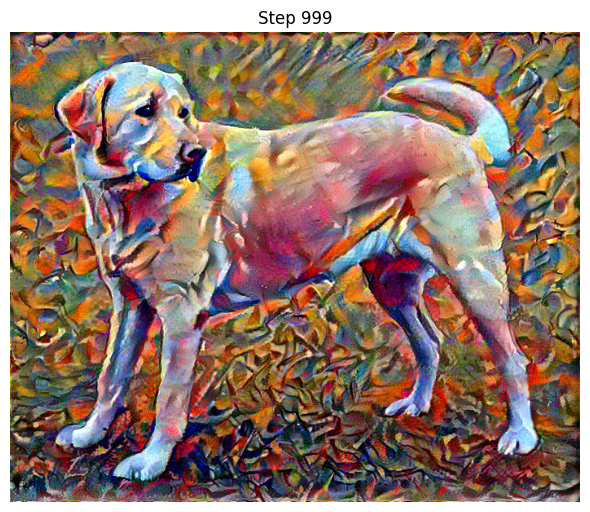

⏱️ Execution time: 31.47 seconds


In [ ]:
# paths to images
content_image_path = data_path+ 'input/YellowLabradorLooking.jpg'
style_image_path = data_path+ 'style/Vassily.jpg'



# Run style transfer
styled_image = run_style_transfer(model, content_image_path, content_weight ,style_image_path, style_weight,style_layer_weights, tv_weight, num_iterations=EPOCH)

Saved config to /content/drive/My Drive/GSU/Spring 2025/CSC 8260 Adv Img Prc/Project/images/configs/YellowLabradorLooking__plus_Vassily__20250420-232952.json
Image saved as /content/drive/My Drive/GSU/Spring 2025/CSC 8260 Adv Img Prc/Project/images/results/YellowLabradorLooking__plus_Vassily__20250420-232952.png
Saved figure to /content/drive/My Drive/GSU/Spring 2025/CSC 8260 Adv Img Prc/Project/images/three_results/YellowLabradorLooking__plus_Vassily__20250420-232952


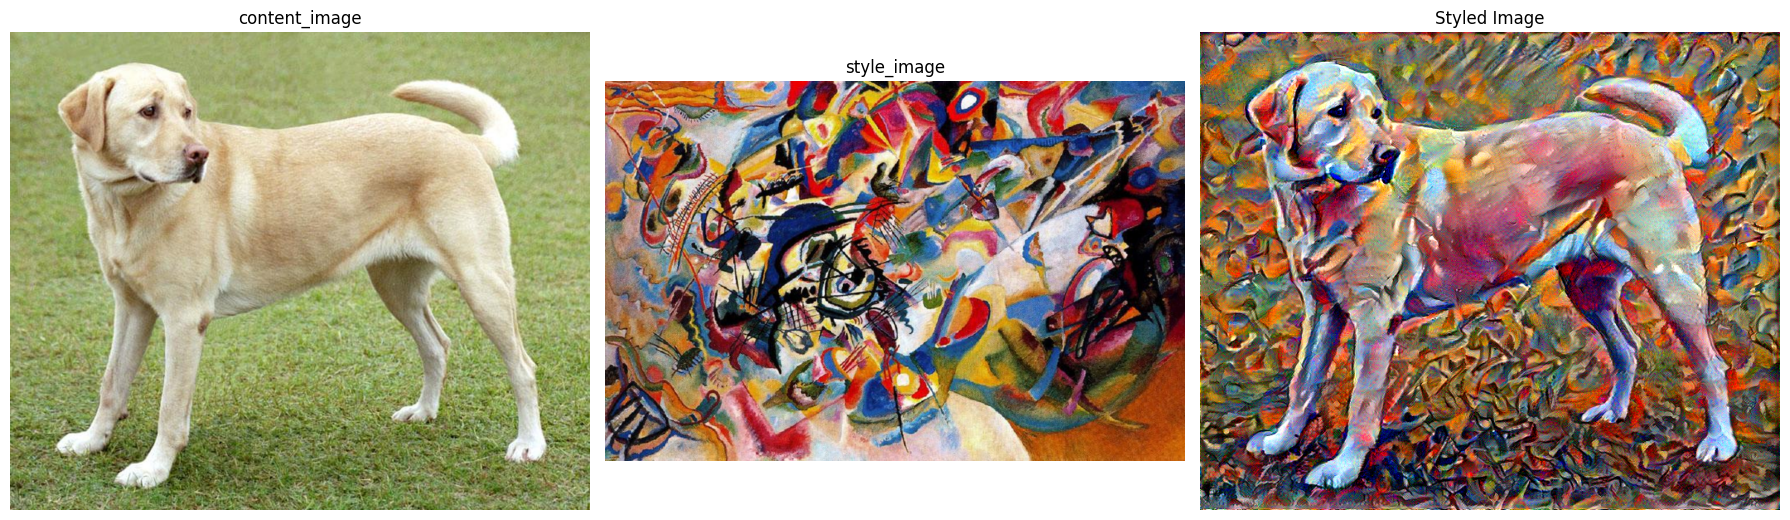

In [ ]:

#  Load and display original images
content_image = load_and_process_img(content_image_path)
style_image = load_and_process_img(style_image_path)

file_name , dpi = save_styled_image(styled_image, content_image_path, style_image_path, data_path)


display_images(
    [content_image,style_image,styled_image],
    ['content_image','style_image','Styled Image'],
    save_path = data_path,
    file_name = file_name,
    set_dpi = dpi
)


In [ ]:
import json

# Load the JSON file from saved configs
with open(data_path+'/configs/'+'gavrem_10000.0__plus_Mykhailo_Boychuk_1910_100.0_20250327-185518.json', 'r') as f:
    loaded_params = json.load(f)

# Assign variables
CONTENT_WEIGHT = loaded_params["content_weight"]
STYLE_WEIGHT =  loaded_params["style_weight"]
style_layer_weights =   loaded_params["style_layer_weights"]
content_image_path = loaded_params["content_image"]
style_image_path =  loaded_params["style_image"]
EPOCH =   loaded_params["num_iterations"]

print(EPOCH)

In [ ]:
# Example setting for each block separately
configs = [
    {"block1_conv1": 1e4, "block2_conv1": 0.0, "block3_conv1": 0.0, "block4_conv1": 0.0, "block5_conv1": 0.0},
    {"block1_conv1": 0.0, "block2_conv1": 1e4, "block3_conv1": 0.0, "block4_conv1": 0.0, "block5_conv1": 0.0},
    {"block1_conv1": 0.0, "block2_conv1": 0.0, "block3_conv1": 1e4, "block4_conv1": 0.0, "block5_conv1": 0.0},
    {"block1_conv1": 0.0, "block2_conv1": 0.0, "block3_conv1": 0.0, "block4_conv1": 1e4, "block5_conv1": 0.0},
    {"block1_conv1": 0.0, "block2_conv1": 0.0, "block3_conv1": 0.0, "block4_conv1": 0.0, "block5_conv1": 1e4},
]

outputs = []

content_weight = 1e5
style_weight = 1e5
tv_weight = 1e-6
EPOCH = 1000
content_image_path = data_path+ 'input/gavrem.jpg'
style_image_path = data_path+ 'style/Mykhailo_Boychuk_1910.jpg'

for config in configs:
    # Run style transfer with only one layer active
    output = run_style_transfer(model, content_image_path, content_weight ,style_image_path, style_weight,config, tv_weight, num_iterations=EPOCH)
    outputs.append(output)

titles = ['Block1 Only', 'Block2 Only', 'Block3 Only', 'Block4 Only', 'Block5 Only']
file_name , dpi = save_styled_image(output, content_image_path, style_image_path, data_path)
display_images(outputs, titles=titles, save_path = data_path, file_name = file_name,   set_dpi = dpi)
